# Analysis: Live Birth Occurrence

In [1]:
library("tidyverse")
library("tidymodels")

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
Warning message:
“package ‘ggplot2’ was built under R version 3.6.2”Warning message:
“package ‘tidyr’ was built under R version 3.6.2”Warning message:
“package ‘dplyr’ was built under R version 3.6.2”── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning message:
“package ‘tidymodels’ was built under R version 3.6.2”── Attaching packages ────────────────────────────────────── tidymodels 0.1.0 ──
✔ broom     0.5.5          ✔ rsample   0.0.5     
✔ dials     0.0.4          ✔ tune      0.0.1.9000
✔ infer     0.5.1          ✔ workflows 0.1.1     
✔ parsnip   0.0.5   

## Pre-processing

In [2]:
ivf_df = read_rds("birth_ivf_cleaned.rds")

In [3]:
ivf_split = ivf_df %>% initial_split(prop=0.8)

In [4]:
proc_rules <- recipe(live_birth_occurr ~ ., data=ivf_split %>% training()) %>% 
    # resample
    step_downsample(live_birth_occurr) %>%
    # transformation
    # step_bagimpute(all_predictors()) %>%
    step_other(all_nominal(), -all_outcomes()) %>%
    step_string2factor(all_nominal()) %>%
    step_dummy(all_nominal(), -all_outcomes()) %>%
    # auto trim
    step_naomit(all_predictors())
    # step_corr(all_numeric()) %>%
    # step_lincomb(all_numeric()) %>%
    # step_nzv(all_numeric())
proc_rules

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor         61

Operations:

Down-sampling based on live_birth_occurr
Collapsing factor levels for all_nominal, -, all_outcomes()
Factor variables from all_nominal
Dummy variables from all_nominal, -, all_outcomes()
Removing rows with NA values in all_predictors

In [5]:
proc_rules_prep = proc_rules %>% prep()
training_df = proc_rules_prep %>% juice()
testing_df = proc_rules_prep %>% bake(new_data=ivf_split %>% testing())

In [6]:
training_df %>% skimr::skim()

── Data Summary ────────────────────────
                           Values    
Name                       Piped data
Number of rows             315397    
Number of columns          116       
_______________________              
Column type frequency:               
  factor                   1         
  numeric                  115       
________________________             
Group variables            None      

── Variable type: factor ───────────────────────────────────────────────────────
  skim_variable     n_missing complete_rate ordered n_unique
1 live_birth_occurr         0             1 FALSE          2
  top_counts          
1 1: 162440, 0: 152957

── Variable type: numeric ──────────────────────────────────────────────────────
    skim_variable                                                       
  1 total_number_of_live_births___conceived_through_ivf                 
  2 type_of_infertility___female_primary                                
  3 type_of_infertility___fe

In [7]:
testing_df %>% skimr::skim()

── Data Summary ────────────────────────
                           Values    
Name                       Piped data
Number of rows             169855    
Number of columns          116       
_______________________              
Column type frequency:               
  factor                   1         
  numeric                  115       
________________________             
Group variables            None      

── Variable type: factor ───────────────────────────────────────────────────────
  skim_variable     n_missing complete_rate ordered n_unique top_counts         
1 live_birth_occurr         0             1 FALSE          2 0: 129447, 1: 40408

── Variable type: numeric ──────────────────────────────────────────────────────
    skim_variable                                                       
  1 cause__of_infertility___tubal_disease                               
  2 cause_of_infertility____partner_sperm_immunological_factors         
  3 cause_of_infertility____partne

## Modelling

In [8]:
model = rand_forest(trees=50, mode="classification") %>%
    set_engine("ranger", importance="permutation")
model_fit = model %>% fit(live_birth_occurr ~ ., data=training_df)
model_fit

parsnip model object

Fit time:  15m 5.2s 
Ranger result

Call:
 ranger::ranger(formula = formula, data = data, num.trees = ~50,      importance = ~"permutation", num.threads = 1, verbose = FALSE,      seed = sample.int(10^5, 1), probability = TRUE) 

Type:                             Probability estimation 
Number of trees:                  50 
Sample size:                      315397 
Number of independent variables:  115 
Mtry:                             10 
Target node size:                 10 
Variable importance mode:         permutation 
Splitrule:                        gini 
OOB prediction error (Brier s.):  0.2075573 

# A tibble: 3 x 3
  .metric  .estimator .estimate
  <chr>    <chr>          <dbl>
1 accuracy binary         0.587
2 kap      binary         0.218
3 roc_auc  binary         0.659


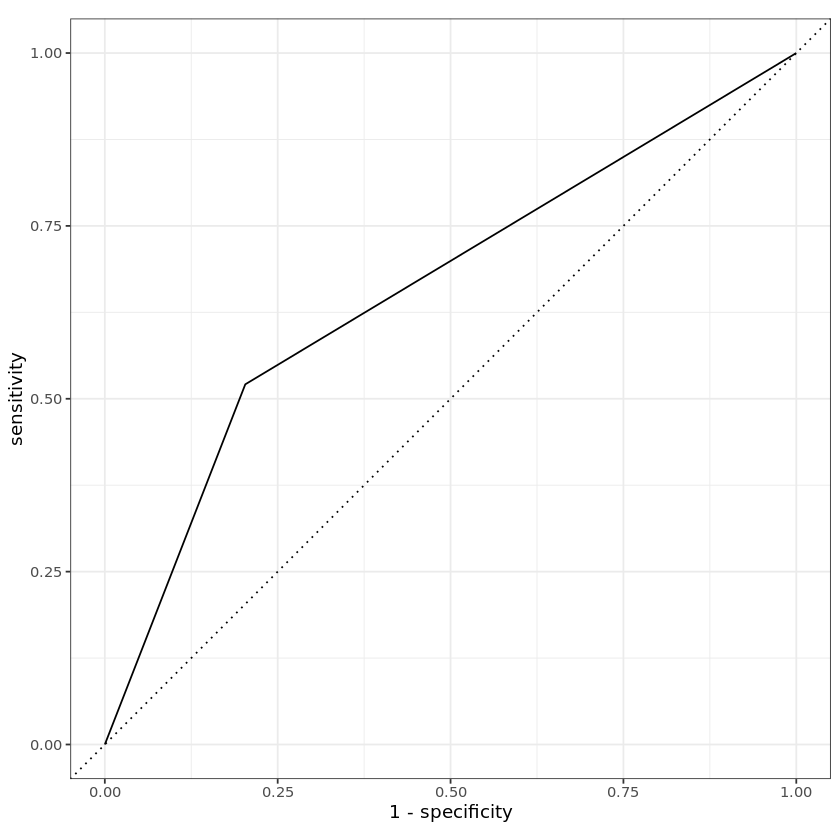

In [13]:
model_pred = model_fit %>% predict(testing_df)

pred_df = model_pred %>% bind_cols(testing_df)
pred_df %>%
    metrics(truth=live_birth_occurr, estimate=.pred_class) %>%
    bind_rows(
        pred_df %>%
            mutate_at(vars(.pred_class), function(x) as.integer(as.character(x))) %>%
            roc_auc(., live_birth_occurr, .pred_class)
    ) %>% print()

pred_df %>%
    mutate_at(vars(.pred_class), function(x) as.integer(as.character(x))) %>%
    roc_curve(., live_birth_occurr, .pred_class) %>%
    autoplot()

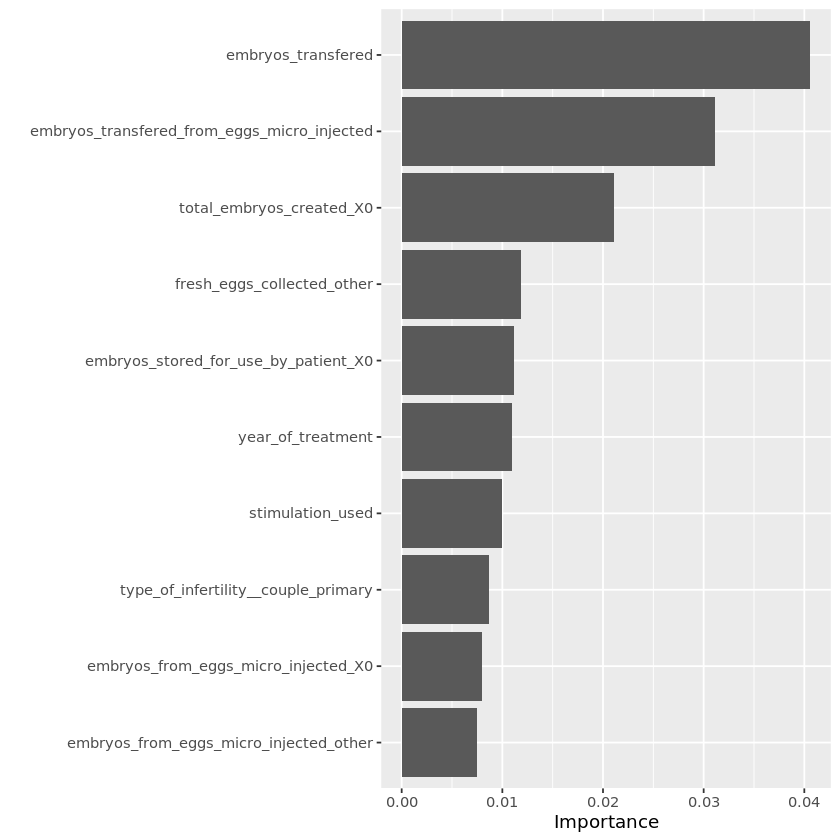

In [14]:
vip::vip(model_fit)